###**SEGMENTACIÓN DE CLIENTES**

####**Grupo 9**
*   Jose Luis Munévar Diaz
*   Angie Catherine Collazos Valenzuela
*   Iván Valderrama Corredor


####**Introducción**


En este trabajo se utiliza la base de datos Online Retail del repositorio UCI Machine Learning, que contiene más de 500 mil transacciones realizadas por una empresa de ventas en línea de Reino Unido entre 2010 y 2011. El objetivo del análisis es explorar técnicas de aprendizaje no supervisado aplicadas a la segmentación de clientes, con el fin de identificar patrones de compra que puedan ser útiles en la toma de decisiones estratégicas. Para ello, se plantearon diferentes hipótesis en torno a modelos de clustering como KMeans, clustering jerárquico y métodos basados en densidad (DBSCAN), evaluando sus supuestos, ventajas y limitaciones frente a la naturaleza de los datos. Posteriormente, se seleccionó una de las hipótesis más adecuadas para el contexto del dataset y se realizaron procesos de preparación y transformación de la base de datos —incluyendo la detección de outliers, transformaciones logarítmicas y estandarización— con el fin de asegurar que los modelos de agrupamiento trabajen con información más robusta y homogénea. Finalmente, se procederá a aplicar el modelo elegido para contrastar la hipótesis planteada y evaluar la calidad de los grupos obtenidos.

####**Entendimiento de los datos**




In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from google.colab import files
import pandas as pd
import kagglehub



path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")


# 2. Información general
print("=== Info general ===")
print(df.info())

print("\n=== Primeras filas ===")
print(df.head())



Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn
=== Info general ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-nu

In [3]:

# 3. Estadísticas descriptivas
print("\n=== Estadísticas descriptivas numéricas ===")
print(df.describe())

print("\n=== Estadísticas categóricas ===")
print(df.describe(include="object"))



=== Estadísticas descriptivas numéricas ===
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

=== Estadísticas categóricas ===
        customerID gender Partner Dependents PhoneService MultipleLines  \
count         7043   7043    7043       7043         7043          7043   
unique        7043      2       2          2            2             3   
top     3186-AJIEK   Male      No         No          Yes            No   
freq             1   3555    3641       4933         6361          3390   

       InternetService OnlineSecurity OnlineBackup DeviceProtection  \
count             7043  

In [4]:
# 4. Valores faltantes
print("\n=== Valores faltantes por columna ===")
print(df.isnull().sum())


=== Valores faltantes por columna ===
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [5]:
# 5. Variables categóricas y numéricas
categoricas = df.select_dtypes(include=["object"]).columns.tolist()
numericas = df.select_dtypes(exclude=["object"]).columns.tolist()

print("\nVariables categóricas:", categoricas)
print("Variables numéricas:", numericas)


Variables categóricas: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
Variables numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


In [ ]:
# 6. Unicidad y duplicados
print("\nDuplicados:", df.duplicated().sum())


Duplicados: 0


####**Análisis**

**Variables numéricas**

Quantity: rango enorme (-80,995 a +80,995) → valores negativos corresponden a devoluciones.

UnitPrice: va desde -11,062 hasta 38,970 → precios negativos no son lógicos, podrían ser errores o devoluciones mal cargadas.

CustomerID: muchos nulos (135,080 ≈ 25% de las filas). Esto limita los análisis a nivel cliente.

InvoiceDate: útil para construir variables como recencia, pero no sirve crudo como predictor.

**Variables categóricas**

InvoiceNo y StockCode: son identificadores, no aportan directamente para clustering.

Description: tiene 1,454 nulos y 4,223 valores únicos → demasiada dispersión para usarla sin procesar.

Country: 38 países, pero United Kingdom domina con 495,478 de 541,909 filas (≈91%).

**Duplicados y nulos**

Hay 5,268 registros duplicados.

25% de CustomerID está vacío → los clientes sin ID no podrían agruparse en un análisis por cliente.

####**Análisis frente a las Hipótesis**

**KMeans**

No viable sobre transacciones individuales (mucho ruido por precios negativos, cantidades extremas).

Viable si se agregan métricas por cliente: gasto total (Quantity × UnitPrice), número de facturas, productos distintos, etc.

Problema: 25% de los registros sin CustomerID no podrán ser considerados en esta hipótesis.

Parámetro crítico: número de clusters.

**Jerárquico**

Imposible con 541k registros (coste computacional).

Factible al reducir a clientes únicos con ID (≈4,000 clientes).

Los nulos en CustomerID implican que el análisis jerárquico perdería ese 25% de datos.

Parámetros: tipo de linkage, nivel de corte en el dendrograma.

**DBSCAN**

Con transacciones en crudo sería impracticable (muchísimos puntos, densidad muy heterogénea).

Requiere también agregación por cliente y normalización de las métricas.

La elección de eps y min_samples es crítica y difícil sin exploración previa.

Riesgo: DBSCAN puede marcar demasiados puntos como ruido si la densidad de clientes es muy variable.

####**Conclusiones**

Al analizar el dataset en su estado original, se observa que ninguna de las tres técnicas de clustering propuestas puede aplicarse de manera directa debido a la presencia de devoluciones (cantidades y precios negativos), valores atípicos extremos y un alto porcentaje de registros sin identificador de cliente. En el caso de KMeans, su aplicación sobre transacciones individuales generaría resultados poco fiables, por lo que es indispensable una agregación a nivel de cliente y la normalización de variables. El clustering jerárquico presenta un problema adicional de escalabilidad, ya que resulta impracticable sobre más de medio millón de registros, aunque sí sería viable si se trabaja únicamente con clientes únicos, reduciendo así la muestra a unas pocas miles de observaciones. Por su parte, DBSCAN enfrenta la dificultad de operar sobre un conjunto tan heterogéneo y masivo, lo que produciría un exceso de puntos clasificados como ruido si no se ajustan con precisión los hiperparámetros; nuevamente, solo sería factible después de una agregación por cliente y escalamiento de variables. En síntesis, la viabilidad de estas hipótesis depende de transformar los datos transaccionales en representaciones más compactas y consistentes a nivel de cliente, siendo KMeans y DBSCAN opciones más adecuadas una vez realizados estos pasos, mientras que el jerárquico, aunque interpretable, sigue limitado por el tamaño de los datos.

####**Elección del modelo**
Tras el análisis del dataset, la hipótesis más viable resulta ser la aplicación de un modelo de clustering basado en centroides (KMeans). Esta técnica ofrece un buen balance entre escalabilidad y capacidad de interpretación, ya que puede manejar sin problemas el número de clientes presentes en la base una vez que los datos se agreguen a nivel de cliente, y además permite evaluar objetivamente la calidad de los grupos mediante métricas como el método del codo o el índice de silhouette. En contraste, el clustering jerárquico presenta serias limitaciones debido al volumen de los datos, lo que lo hace impracticable en su estado actual, mientras que DBSCAN, aunque útil para detectar patrones irregulares o clientes atípicos, es altamente sensible a la elección de parámetros y corre el riesgo de generar un alto porcentaje de ruido en una base tan heterogénea. En consecuencia, KMeans se posiciona como la opción más adecuada para este caso, siempre que se realicen previamente la agregación por cliente y la normalización de variables.

###**Hipótesis elegida: KMeans**

Podemos utilizar la fortaleza principal de KMeans, que es la definición del número de clusters, para segmentar a los clientes en 3 a 5 grupos representativos (por ejemplo: Bronce, Plata, Oro y Platino). Esta segmentación busca simplificar la explicación de resultados y aportar al diseño de estrategias comerciales diferenciadas. Para ello, se utilizarán las variables Quantity (cantidad total comprada) y TotalPrice (valor total gastado) como ejes principales, calculando los centroides más precisos que permitan identificar patrones de consumo. La elección de K se realizará apoyándonos en métricas de validación interna como el método del codo y el índice de silhouette, asegurando la calidad de los clusters resultantes.

####**Limpieza de los datos**

In [13]:
# LIMPIEZA PARA HIPÓTESIS KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Eliminar duplicados
df = df.drop_duplicates()

#Eliminar registros con CustomerID nulo (indispensable para agrupar clientes)
df = df.dropna(subset=["customerID"])

df.describe


<bound method NDFrame.describe of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95        1889.5   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
0       No  
1       No  
2      Yes  
3       No  
4      Yes  
...    ...  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[7043 rows x 21 columns]>

In [15]:
print(df.columns)


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


En la etapa de limpieza se decidió eliminar los registros con CustomerID nulo, dado que la hipótesis de segmentación se centra en agrupar clientes y no transacciones individuales. Aunque esta decisión reduce aproximadamente un 25% de las observaciones, se consideró necesaria para garantizar que cada registro pueda asociarse a un cliente único. No obstante, se reconoce como limitación que esta exclusión puede afectar la representatividad de clientes anónimos o no identificados en la base de datos.

In [16]:

# Filtrar registros inválidos (cantidades y precios <= 0)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Crear variable de importe total de la transacción
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]




KeyError: 'Quantity'

En la etapa de limpieza se eliminaron registros con cantidades y precios menores o iguales a cero, pues estos correspondían a devoluciones, cancelaciones o errores de registro que distorsionan el análisis del gasto real de los clientes. Con este filtrado se garantiza que las transacciones reflejen únicamente compras efectivas. Adicionalmente, se creó la variable TotalPrice como el producto de Quantity y UnitPrice, la cual representa el importe total de cada transacción y servirá como variable clave para la segmentación.

In [ ]:
# AGREGACIÓN A NIVEL CLIENTE
df_customer = df.groupby("CustomerID").agg({
    "Quantity": "sum",       # Cantidad total de ítems comprados
    "TotalPrice": "sum"      # Total gastado
}).reset_index()

print("\nVista previa de datos a nivel cliente:")
print(df_customer.head())

KeyError: 'CustomerID'

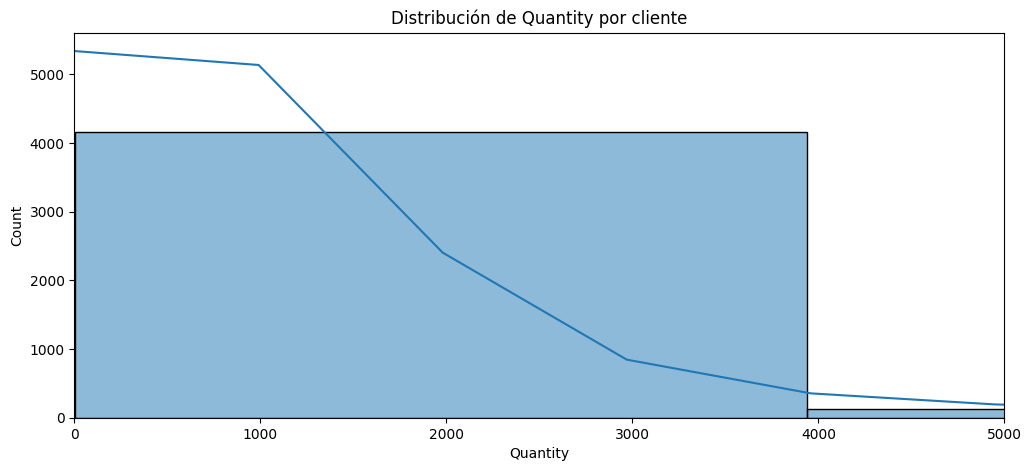

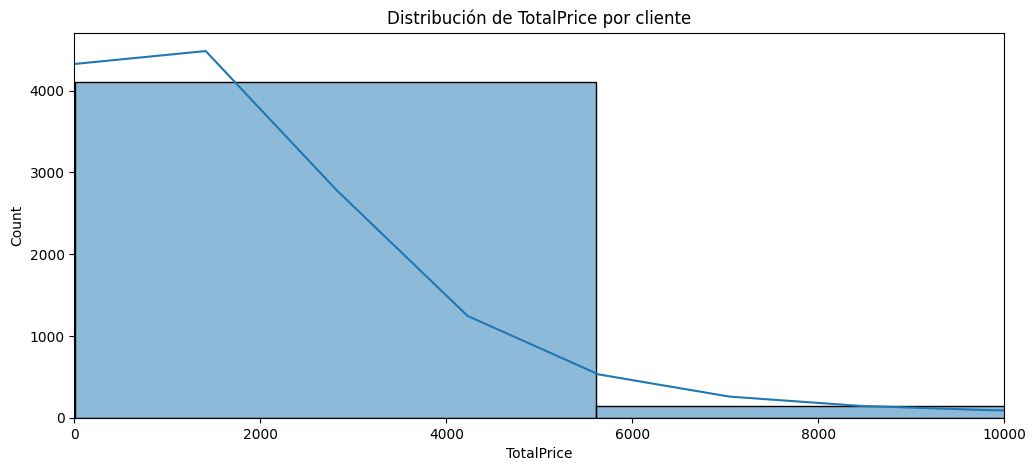

In [ ]:
# VISUALIZACIONES INICIALES
plt.figure(figsize=(12,5))
sns.histplot(df_customer["Quantity"], bins=50, kde=True)
plt.title("Distribución de Quantity por cliente")
plt.xlim(0, 5000)  # limitar eje para ver mejor
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_customer["TotalPrice"], bins=50, kde=True)
plt.title("Distribución de TotalPrice por cliente")
plt.xlim(0, 10000)  # limitar eje para ver mejor
plt.show()



In [ ]:
# NORMALIZACIÓN
from sklearn.preprocessing import StandardScaler

X = df_customer[["Quantity", "TotalPrice"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nShape final de X:", X_scaled.shape)


Shape final de X: (4338, 2)


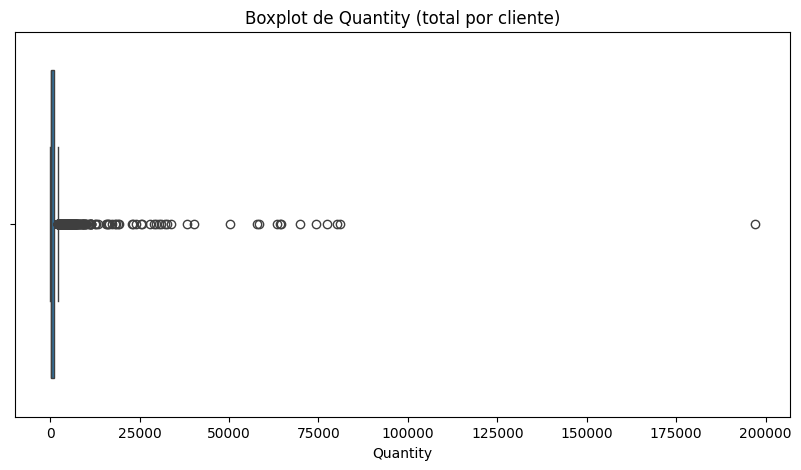

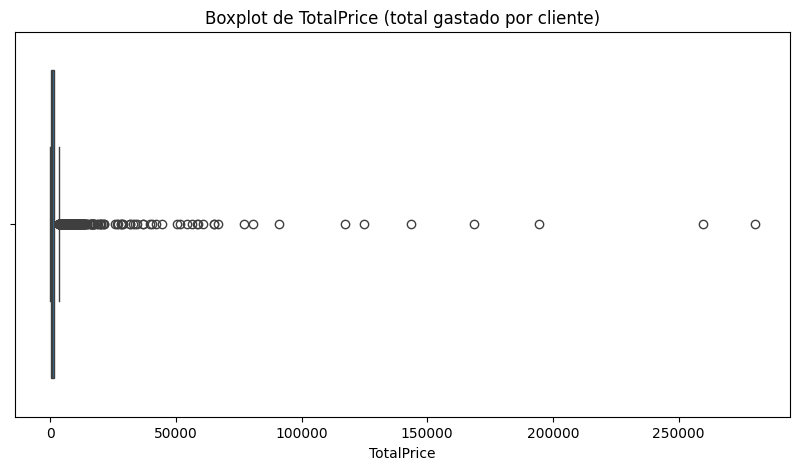

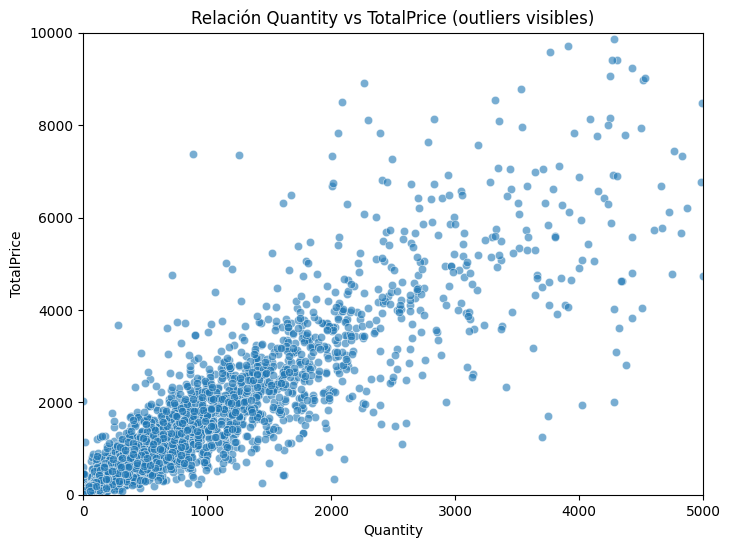

In [ ]:
# BOXplots para detectar outliers
plt.figure(figsize=(10,5))
sns.boxplot(x=df_customer["Quantity"])
plt.title("Boxplot de Quantity (total por cliente)")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df_customer["TotalPrice"])
plt.title("Boxplot de TotalPrice (total gastado por cliente)")
plt.show()

# También gráfico combinado
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_customer,
    x="Quantity",
    y="TotalPrice",
    alpha=0.6
)
plt.title("Relación Quantity vs TotalPrice (outliers visibles)")
plt.xlim(0, 5000)   # recortar ejes para ver mejor
plt.ylim(0, 10000)
plt.show()


####**Manejo de outliers**

In [ ]:

# Aplicar log-transform
df_customer["Quantity_log"] = np.log1p(df_customer["Quantity"])
df_customer["TotalPrice_log"] = np.log1p(df_customer["TotalPrice"])




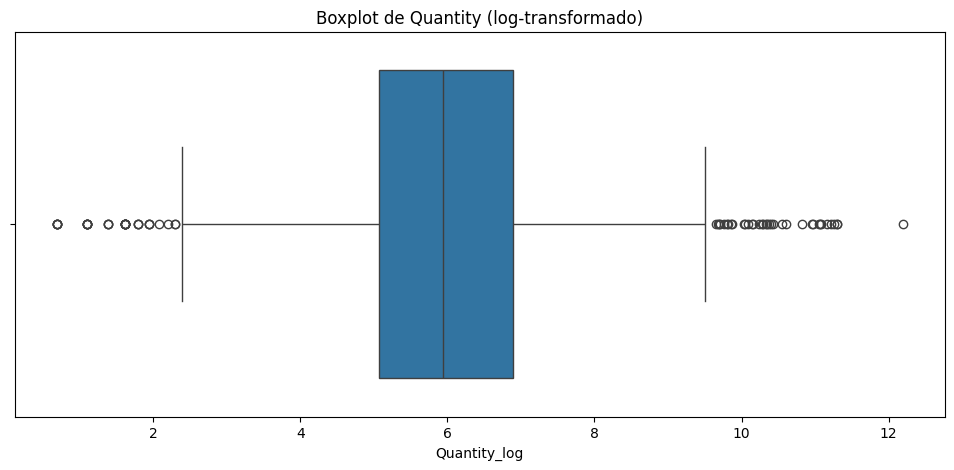

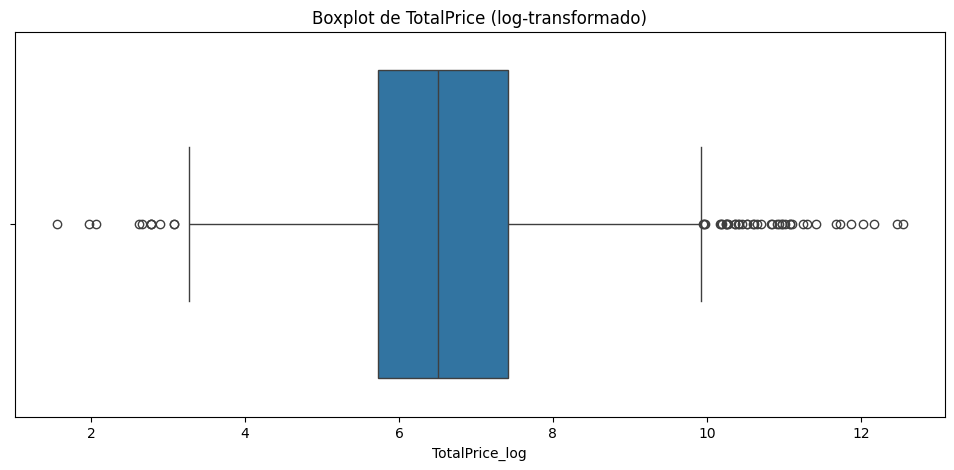

In [ ]:
# Boxplots después del log

plt.figure(figsize=(12,5))
sns.boxplot(x=df_customer["Quantity_log"])
plt.title("Boxplot de Quantity (log-transformado)")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x=df_customer["TotalPrice_log"])
plt.title("Boxplot de TotalPrice (log-transformado)")
plt.show()

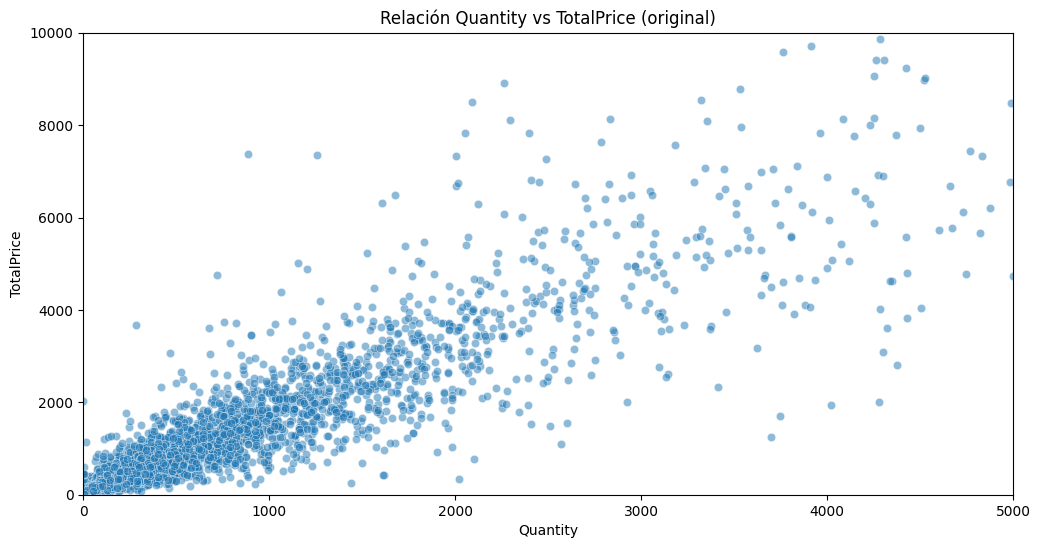

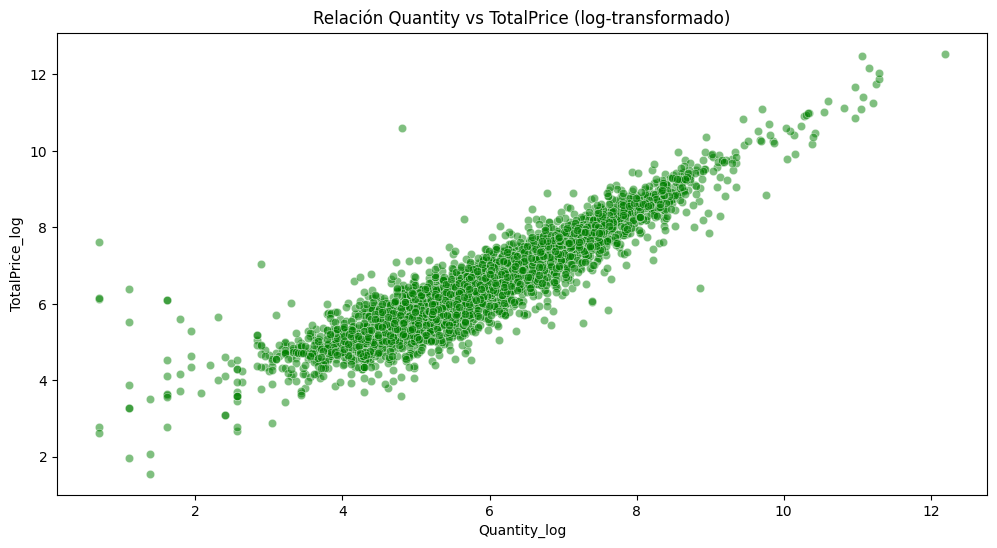

In [ ]:
# =========================
# Comparación scatter antes vs después
# =========================
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_customer, x="Quantity", y="TotalPrice", alpha=0.5)
plt.title("Relación Quantity vs TotalPrice (original)")
plt.xlim(0,5000)
plt.ylim(0,10000)
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_customer, x="Quantity_log", y="TotalPrice_log", alpha=0.5, color="green")
plt.title("Relación Quantity vs TotalPrice (log-transformado)")
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Selección de variables log-transformadas
X_log = df_customer[["Quantity_log", "TotalPrice_log"]]

# Estandarización
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

print("Shape final de X_log_scaled:", X_log_scaled.shape)


Shape final de X_log_scaled: (4338, 2)


Para el análisis de clustering con KMeans decidimos trabajar con las variables transformadas en logaritmo (Quantity_log y TotalPrice_log), ya que esta transformación permitió reducir la fuerte asimetría y el impacto de los valores atípicos presentes en los datos originales. De esta manera, la distribución de las observaciones se vuelve más compacta y homogénea, lo cual facilita que el algoritmo identifique patrones de comportamiento más claros. Además, tras aplicar la transformación, realizamos una estandarización con StandardScaler para garantizar que ambas variables contribuyan de forma equilibrada al cálculo de las distancias, evitando que la escala de una de ellas domine el proceso de agrupamiento.